# Two Nucleon Scattering #

Consider two nucleons each of mass $m=938$ MeV/$c^2$
interacting via a central potential given by

$$
V(r) = 
\begin{cases}
              -V_0\, \quad\quad           & \text{for }                r \leq R \,  \\
{\color{white}-}0 \, \quad\quad           & \text{otherwise }\,  \\
\end{cases}
$$

where $V_0$ is positive and $R=1.45$ fm.

In [1]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt

## Numerov's algorithm ##

We seek the solution, $u(r)=r\,R(r)$, of the radial equation
\begin{equation}
 -\frac{\hbar^2}{2\,\mu}u^{\prime\prime}(r) +V(r)\,u(r) +\frac{\ell(\ell+1)}{r^2}=E\,u(r)\, ,
\end{equation}
where 
\begin{eqnarray}
 E&=&\frac{\hbar^2\,k^2}{2\,\mu}\, , \quad {\rm and}\quad \quad  \mu=\frac{m}{2} \, .
\end{eqnarray}
We define
\begin{equation}
 v(r)=\frac{2\,\mu}{\hbar^2}\,V(r) \, ,
\end{equation}
and rewrite the equation above  as
\begin{eqnarray}
&& u^{\prime\prime}(r) +\left[k^2 - v(r)\,u(r) -\frac{\ell(\ell+1)}{r^2}\right]\,u(r)=0\, ,\nonumber 
\end{eqnarray}
or
\begin{eqnarray}
&& u^{\prime\prime}(r) + K(r) u(r)=0 \, ,
\end{eqnarray}
with 
\begin{equation}
 K(r)=\frac{2\,\mu}{\hbar^2}\left[E-V(r)\right] - \frac{\ell(\ell+1)}{r^2} \, .
\end{equation}

As $r\rightarrow 0$, $u(r)\rightarrow r^{(\ell+1)}$. We use two grid points 
close to zero *e.g.*, $r_1=h$ and $r_2=2\times h$, where $h$ is the 
step in $r$), and the solution calculated in these points, that is 
$u_1=u(r_1)=h^{\ell+1}$ and $u_2=u(r_2)=(2\times h)^{\ell+1}$, to start building the
solution outwards using the Numerov's method. 

The subsequent $u_i$'s calculated at $r_i$'s are obtained using the following
algorithm
\begin{equation}
u_{i+1}\left(1+\frac{h^2}{12}K_{i+1} \right) -u_i\,\left(2-\frac{5\,h^2}{6}K_i\right)+
u_{i-1}\left(1+\frac{h^2}{12}K_{i-1} \right) +O(h^6)=0 \nonumber \, . 
\end{equation}
 
You will need the physical constant $\hbar\,c = 197.326980$ MeV fm.

In [2]:
#Lets define some common variables
mu = 938/2 #MeV/c^2
hbarc = 197.326980 #MeV fm

In [3]:
def numerovWF(E,V0,R,l,n,Rmax):
    '''Uses Numerov's algorithm to solve the radial equation and get the wavefunction for a nucleon 
    with energy E, scattered off of a potential V0. l is the angular momentum of the partial wave
    under consideration.
    n=number of points
    R=radius of potential
    Rmax=max integration point'''

    h = Rmax/n

    #Set up array for wavefuntion
    wavefunc = np.zeros(n)
    r = np.arange(h, Rmax+h, h)
    V = np.zeros_like(r)

    for i in range(len(V)):
        if r[i] <= R:
            V[i] = V0

    K = 2*mu/hbarc**2*(E*np.ones_like(r) - V) - l*(l+1)/r**2

    #solve approximation for first two steps r0 and r1
    wavefunc[0] = r[0]**(l+1)
    wavefunc[1] = r[1]**(l+1)

    #loop over the rest of the wavefunction calculating r_i+1
    for i in range(2,n):
        wavefunc[i] = 1/(1+h**2/12*K[i])*(wavefunc[i-1]*(2-5*h**2*K[i-1]/6) - wavefunc[i-2]*(1+h**2*K[i-2]/12))
    
    #normalize the wavefunction
    norm = 0
    for i in range(n):
        norm += (wavefunc[i]*r[i])**2
    wavefunc /= np.sqrt(norm)/100
    
    return wavefunc

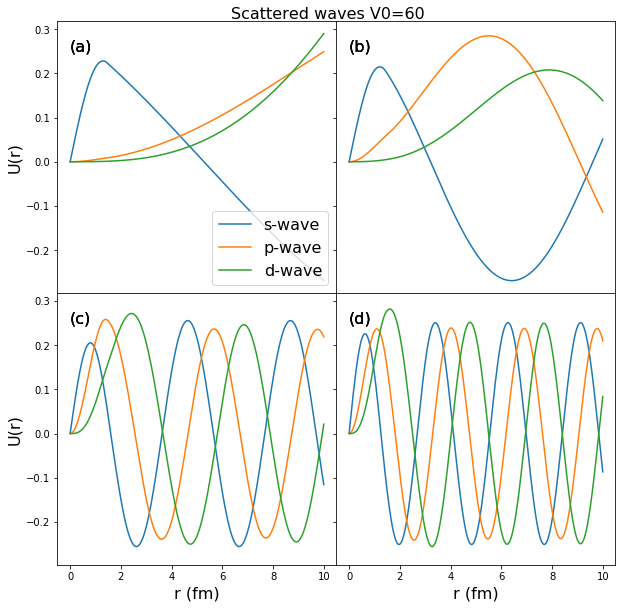

In [4]:
V0 = -60
R = 1.45
l = 2
n = 10000
Rmax = 10

h = Rmax/n 
r = np.arange(h, Rmax+h, h)


fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
fig.suptitle("Scattered waves V0=60", y=0.9, size = 16)
fig.subplots_adjust(wspace=0, hspace=0)

energies = [1,10,100,200]
labels = ['s-wave','p-wave','d-wave']

e = 1
for l in range(3):
    wavefunc = numerovWF(e, V0, R, l, n, Rmax)
    k = np.sqrt(2*mu*e/hbarc**2)
    axs[0,0].plot(r, wavefunc, label=labels[l])
    axs[0,0].text(0,0.25, "(a)",dict(size=16))
    axs[0,0].legend(loc="lower right", prop={'size':16})
    axs[0,0].set_ylabel('U(r)',size=16)
e = 10
for l in range(3):
    wavefunc = numerovWF(e, V0, R, l, n, Rmax)
    k = np.sqrt(2*mu*e/hbarc**2)
    axs[0,1].plot(r, wavefunc, label=labels[l])
    axs[0,1].text(0,0.25, "(b)",dict(size=16))
e = 100
for l in range(3):
    wavefunc = numerovWF(e, V0, R, l, n, Rmax)
    k = np.sqrt(2*mu*e/hbarc**2)
    axs[1,0].plot(r, wavefunc, label=labels[l])
    axs[1,0].text(0,0.25, "(c)",dict(size=16))
    axs[1,0].set_xlabel('r (fm)',size=16)
    axs[1,0].set_ylabel('U(r)',size=16)
e = 200
for l in range(3):
    wavefunc = numerovWF(e, V0, R, l, n, Rmax)
    k = np.sqrt(2*mu*e/hbarc**2)
    axs[1,1].plot(r, wavefunc, label=labels[l])
    axs[1,1].text(0,0.25, "(d)",dict(size=16))
    axs[1,1].set_xlabel('r (fm)',size=16)
    
    
fig.savefig("Wavefuncs_V0=60.png".format(e,V0), format="png")

## phaseshifts ##


Analytical solution for the S-wave Phase shift
$$ \delta_0=\arctan{\frac{\cos{(kR)}\,\sin{(KR)}-\frac{K}{k}\,\cos{(KR)}\sin{(kR)}}{\frac{K}{k}\,\cos{(kR)}\cos{(KR)}+\sin{(kR)}\sin{(KR)}}}. $$


calculated cross section from phase shifts
$$ \sigma=4\,\frac{\pi}{k^2}\,\sum_{l=0}^{\infty}\,(2l+1)\,\sin^2{(\delta_l)}\ $$


In [5]:
def phaseshift(wavefunc,E,l,n,Rmax):
    '''Get the phaseshift from a scattered wave'''
    h = Rmax/n
    r1 = Rmax - h
    r2 = Rmax
    
    #get wave momentum
    k = np.sqrt(2*mu*E/hbarc**2)
    alpha = (wavefunc[len(wavefunc)-2]/r1)/(wavefunc[len(wavefunc)-1]/r2)
    
    tandelta = (sp.spherical_jn(l,k*r1) - alpha*sp.spherical_jn(l,k*r2))/ \
                (sp.spherical_yn(l,k*r1) - alpha*sp.spherical_yn(l,k*r2))
    
    phaseshift = np.arctan(tandelta)
    
    if phaseshift < 0:
        phaseshift += np.pi
    
    return phaseshift

In [6]:
def phaseshift_analytical(E,V0):
    
    K1 = np.sqrt(2*mu/hbarc**2*(E - V0))
    K0 = np.sqrt(2*mu*E/hbarc**2)
    
    tandelta = (np.cos(K0*R)*np.sin(K1*R) - K1/K0*np.cos(K1*R)*np.sin(K0*R))/ \
                   (K1/K0*np.cos(K1*R)*np.cos(K0*R) + np.sin(K1*R)*np.sin(K0*R))
    #tandelta_n = np.abs(np.cos(K0*R)*np.sin(K1*R) - K1/K0*np.cos(K1*R)*np.sin(K0*R))
    #tandelta_d = np.abs(K1/K0*np.cos(K1*R)*np.cos(K0*R) + np.sin(K1*R)*np.sin(K0*R))
    
    #phaseshift = np.arctan2(tandelta_n,tandelta_d)
    phaseshift = np.arctan(tandelta)
    if phaseshift < 0:
        phaseshift += np.pi
    
    return phaseshift


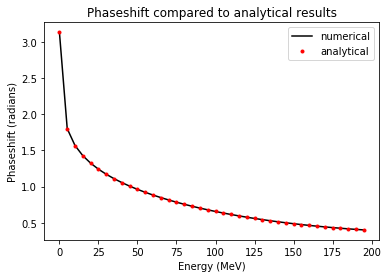

In [7]:
V0 = -60
l=0
phases = []
phases_analytical = []
energies = np.arange(0.0001,200,5)
energies_analytical = []

for i,e in enumerate(energies):
    wavefunc = numerovWF(e, V0, R, l, n, Rmax)
    ps = phaseshift(wavefunc, e, l, n, Rmax)
    phases.append(ps)

    ps_analytical = phaseshift_analytical(e,V0)
    phases_analytical.append(ps_analytical)
        
plt.plot(energies, phases, color='black', label="numerical")
plt.plot(energies, phases_analytical, 'r.', label="analytical")
                                 
plt.legend()
plt.title("Phaseshift compared to analytical results")
plt.xlabel("Energy (MeV)")
plt.ylabel("Phaseshift (radians)")
plt.savefig("PhaseshiftAnalytical60.png", format="png")
plt.show()

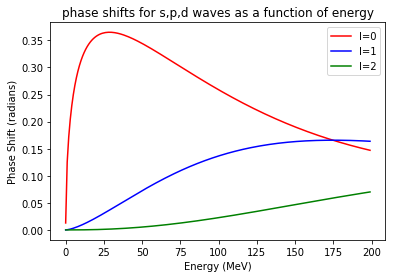

In [8]:
V0 = -20
colors = ["red","blue","green"]
for l in range(3):
    phases = []
    energies = np.arange(0.01,200,1)
    for e in energies:
        wavefunc = numerovWF(e, V0, R, l, n, Rmax)
        ps = phaseshift(wavefunc, e, l, n, Rmax)
        phases.append(ps)

    plt.plot(energies, phases, color=colors[l], label="l={}".format(l))

    
plt.title("phase shifts for s,p,d waves as a function of energy")    
plt.xlabel("Energy (MeV)")
plt.ylabel("Phase Shift (radians)")
plt.legend()
#plt.savefig("PhaseshiftSPDvsEnergy.png", format="png")
plt.show()

## Cross section ##

In [9]:
def partial_xsection(l,ps,E):
    
    k = np.sqrt(2*mu*E/hbarc**2)
    xsec = (2*l+1)*4*np.pi*(np.sin(ps)**2)/k**2
    return 10*xsec #returns in units of mb


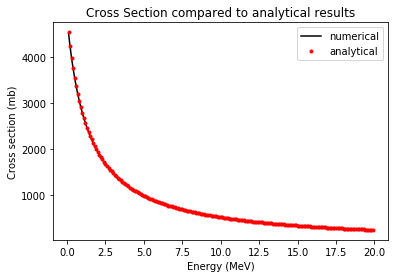

In [10]:
energies = np.arange(0.1,20,0.1)

xsecs = []
xsecs_analytical = []
V0 = -60
l = 0
for i,e in enumerate(energies):
    wavefunc = numerovWF(e, V0, R, l, n, Rmax)
    ps = phaseshift(wavefunc, e, l, n, Rmax)
    ps_analytical = phaseshift_analytical(e,V0)
    
    xsec = partial_xsection(l,ps,e)
    xsec_analytical = partial_xsection(l,ps_analytical,e)
    
    xsecs.append(xsec)
    xsecs_analytical.append(xsec_analytical)
    
plt.plot(energies, xsecs, "k-",label="numerical")
plt.plot(energies, xsecs_analytical, 'r.', label="analytical")
plt.legend()
plt.title("Cross Section compared to analytical results")
plt.xlabel("Energy (MeV)")
plt.ylabel("Cross section (mb)")
#plt.savefig("XsecAnalytical60.png", format="png")
plt.show()

In [11]:
energies = [1,10,100,200]
for e in energies:
    xsec = []
    for l in range(3):
        wavefunc = numerovWF(e, V0, R, l, n, Rmax)
        ps = phaseshift(wavefunc, e, l, n, Rmax)
        xsec.append(partial_xsection(l,ps,e))
        
    totalxsec = xsec[0] + xsec[1] + xsec [2]
    print("Energy {0}Mev \t Cross section {1:.4f}mb \t s:{2:.4f}mb \t p:{3:.4f}mb \t d:{4:.4f}mb".format(e,totalxsec,xsec[0],xsec[1],xsec[2]))    

Energy 1Mev 	 Cross section 2781.9379mb 	 s:2781.9192mb 	 p:0.0187mb 	 d:0.0000mb
Energy 10Mev 	 Cross section 523.4745mb 	 s:521.6418mb 	 p:1.8323mb 	 d:0.0004mb
Energy 100Mev 	 Cross section 57.3172mb 	 s:19.3789mb 	 p:36.2496mb 	 d:1.6887mb
Energy 200Mev 	 Cross section 28.5828mb 	 s:3.8432mb 	 p:16.9249mb 	 d:7.8147mb


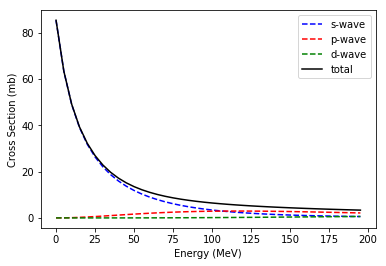

In [12]:
energies = np.arange(0.1,200,5)
V0 = -20
xsecs_all = np.zeros((3,len(energies)))
for l in range(3):
    for i,e in enumerate(energies):
        wavefunc = numerovWF(e, V0, R, l, n, Rmax)
        ps = phaseshift(wavefunc, e, l, n, Rmax)
        xsec = partial_xsection(l,ps,e)
        xsecs_all[l][i] = xsec
plt.plot(energies, xsecs_all[0], 'b--', label="s-wave")
plt.plot(energies, xsecs_all[1], 'r--', label="p-wave")
plt.plot(energies, xsecs_all[2], 'g--', label="d-wave")
plt.plot(energies, xsecs_all[0]+xsecs_all[1]+xsecs_all[2], 'k', label="total")
plt.legend()
plt.xlabel("Energy (MeV)")
plt.ylabel("Cross Section (mb)")
plt.savefig("XsecEnergy.png", format="png")
plt.show()